#Dataset

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# Unzip the files
!unzip train2017.zip
!unzip annotations_trainval2017.zip

--2024-08-08 03:01:07--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.37.201, 3.5.16.53, 54.231.226.1, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.37.201|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip.1’

train2017.zip.1      27%[====>               ]   5.02G  55.6MB/s    eta 4m 7s  ^C
--2024-08-08 03:02:42--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.73.121, 3.5.2.74, 52.217.236.57, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.73.121|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip.1’

annotations_trainva 100%[===================>] 241.19M  55.1MB/s    in 4.9s    

2024-08-08 03

In [ ]:
!pip install pycocotools

In [ ]:
from pycocotools.coco import COCO

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=2
):

  # Use COCO to load the dataset
  train_coco = COCO(os.path.join('/content/annotations', 'instances_train2017.json'))
  test_coco = COCO(os.path.join('/content/annotations', 'instances_val2017.json'))

  # ... code to create dataloaders using COCO API ...

In [ ]:
train_dir = '/content/train2017'
test_dir = '/content/val2017' # You may need to download the validation set separately

# ... other code ...

vit = ViT(num_classes=80) # COCO has 80 classes

# ... other code ...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Robotics_AI_Projects/227.v1i.folder.zip -d /content/

Streaming output truncated to the last 5000 lines.
 extracting: /content/train/Nityakalyani/Nityakalyani154_jpg.rf.71887803d8db23178bb5e6aceab7d72c.jpg  
 extracting: /content/train/Nityakalyani/Nityakalyani155_jpg.rf.e9967f3ca6f8b61338e4d8fe301fc6c2.jpg  
 extracting: /content/train/Nityakalyani/Nityakalyani156_jpg.rf.ee33086f27f186e9d0443262e23f1a64.jpg  
 extracting: /content/train/Nityakalyani/Nityakalyani157_jpg.rf.82589810ff9fc59649017a7f6c1d12db.jpg  
 extracting: /content/train/Nityakalyani/Nityakalyani158_jpg.rf.b8f71370c4b37dae0c666bd2fe3a1943.jpg  
 extracting: /content/train/Nityakalyani/Nityakalyani160_jpg.rf.3d17114a9e9e9a65abd79750f63c85d1.jpg  
 extracting: /content/train/Nityakalyani/Nityakalyani161_jpg.rf.9129fb80edb1fdab925febeeafed5764.jpg  
 extracting: /content/train/Nityakalyani/Nityakalyani162_jpg.rf.f839ce0be5c63e4fcd962638f25c9a00.jpg  
 extracting: /content/train/Nityakalyani/Nityakalyani163_jpg.rf.dbbb737e305aa0b65c1ecc2a6fc26612.jpg  
 extracting: /content/

#Model Code starts here

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'


In [ ]:
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [ ]:
IMG_SIZE = 224

In [ ]:
# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

# Set the batch size
BATCH_SIZE = 32

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]



Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


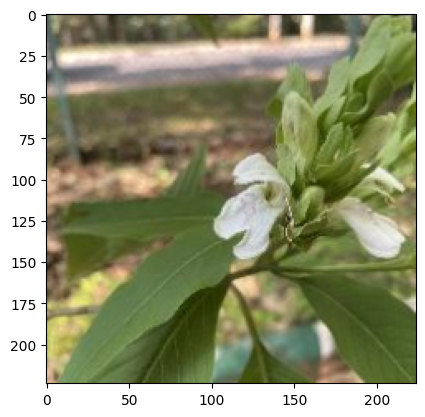

In [ ]:
plt.imshow(image.permute(1, 2, 0))

In [ ]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patch_size = patch_size  # Store patch size for use in forward method

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]


# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)



set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")



# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.rand(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.rand(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable


# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")
#patch_and_position_embedding

print(patch_embedding_class_token)  #1 is added in the beginning of each

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
tensor([[[ 0.2714,  0.5157,  0.5578,  ...,  0.7533,  0.2470,  0.0189],
         [-0.6193,  0.1579, -0.1409,  ...,  0.4052, -0.2383,  0.2315],
         [-0.3108,  0.1329, -0.1387,  ...,  0.2807, -0.2628,  0.1201],
         ...,
         [-0.4126,  0.0693, -0.2563,  ...,  0.3444, -0.1864,  0.2223],
         [-0.3571,  0.0984, -0.1468,  ...,  0.2809, -0.1474,  0.1192],
         [-0.3712,  0.1145, -0.1445,  ...,  0.2619, -0.1762,  0.1412]]],
       grad_fn=<CatBackward0>)


In [ ]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

    # 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

    # 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

    # 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x




In [ ]:
print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
!git clone https://github.com/AarohiSingla/Image-Classification-Using-Vision-transformer
!mv Image-Classification-Using-Vision-transformer/going_modular .
!mv Image-Classification-Using-Vision-transformer/helper_functions.py . # get the helper_functions.py script
!rm -rf Image-Classification-Using-Vision-transformer
from going_modular import engine

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
fatal: destination path 'Image-Classification-Using-Vision-transformer' already exists and is not an empty directory.
mv: cannot move 'Image-Classification-Using-Vision-transformer/going_modular' to './going_modular': Directory not empty
mv: cannot stat 'Image-Classification-Using-Vision-transformer/helper_functions.py': No such file or directory


In [ ]:
# Train our MOdel

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))
try:
    from going_modular.going_modular import engine
except:
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/AarohiSingla/Image-Classification-Using-Vision-transformer
    !mv Image-Classification-Using-Vision-transformer/going_modular .
    !mv Image-Classification-Using-Vision-transformer/helper_functions.py . # get the helper_functions.py script
    !rm -rf Image-Classification-Using-Vision-transformer
    from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'Image-Classification-Using-Vision-transformer'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 43 (delta 12), reused 8 (delta 8), pack-reused 29
Receiving objects: 100% (43/43), 862.14 KiB | 9.27 MiB/s, done.
Resolving deltas: 100% (15/15), done.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.5894 | train_acc: 0.0402 | test_loss: 3.4602 | test_acc: 0.0357
Epoch: 2 | train_loss: 3.4037 | train_acc: 0.0456 | test_loss: 3.3742 | test_acc: 0.0312
Epoch: 3 | train_loss: 3.3375 | train_acc: 0.0443 | test_loss: 3.3325 | test_acc: 0.0357
Epoch: 4 | train_loss: 3.3238 | train_acc: 0.0486 | test_loss: 3.3280 | test_acc: 0.0357
Epoch: 5 | train_loss: 3.3267 | train_acc: 0.0506 | test_loss: 3.3302 | test_acc: 0.0446
Epoch: 6 | train_loss: 3.3286 | train_acc: 0.0503 | test_loss: 3.3302 | test_acc: 0.0446
Epoch: 7 | train_loss: 3.3289 | train_acc: 0.0468 | test_loss: 3.3309 | test_acc: 0.0446
Epoch: 8 | train_loss: 3.3291 | train_acc: 0.0515 | test_loss: 3.3308 | test_acc: 0.0446
Epoch: 9 | train_loss: 3.3293 | train_acc: 0.0525 | test_loss: 3.3301 | test_acc: 0.0312
Epoch: 10 | train_loss: 3.3290 | train_acc: 0.0486 | test_loss: 3.3302 | test_acc: 0.0446


In [ ]:
# prompt: show me predictions

from helper_functions import pred_and_plot_image
from PIL import Image


image = Image.open("/content/train/Hibiscus/Hibiscus102_jpg.rf.19810a64997957bf6f36ff8366e898eb.jpg")

# Make predictions on a single image
pred_and_plot_image(model=vit,
                    image = image,
                    class_names=class_names,
                    transform=manual_transforms,
                    device=device)

TypeError: pred_and_plot_image() got an unexpected keyword argument 'image'

In [ ]:
""